In [1]:
import sys
sys.path.append('modules/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from importlib import reload
import pickle
from Bio import SeqIO
import scipy.io as sio
import scipy
sns.set_style('white')
from importlib import reload
from scipy import stats
import re
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
from collections import defaultdict
import logomaker
from Bio import motifs as mots
import glob
import matplotlib
from scipy.ndimage.filters import gaussian_filter1d
import figures as fg
import general_figures as gn
import statsmodels.api as sm
from itertools import repeat
from collections import defaultdict
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import math
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['pdf.fonttype'] = 42

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from matplotlib import font_manager

# font_dirs = ['/home/labs/barkailab/vovam/stuff/fonts']
# font_files = font_manager.findSystemFonts(fontpaths=font_dirs, fontext='ttf')
# for font_file in font_files:
#     print(font_file)
#     font_manager.fontManager.addfont(font_file)
# plt.rcParams['font.family'] = 'Myriad Pro'

# Load all the data, filter, rename, and bin

In [2]:
by_facs = {'Gal4':{'Full':3.31, 'Gal4AD': 3.341, 'Gcn4AD': 3.341},
          'Gcn4':{'Full': 3.27, 'Gal4AD': 3.32 , 'Gcn4AD': 3.32 },
          'Mig3':{'Full':3.26, 'Gal4AD':3.32 , 'Gcn4AD': 3.32 },
          'Yap1':{'Full':3.31, 'Gal4AD':3.3 , 'Gcn4AD':3.3 },
          'Msn2':{'Full':3.592, 'Gal4AD':3.62 , 'Gcn4AD':3.62 },}
directions = {'Msn2':['upregulated','upregulated','upregulated'],
            'Mig3':['downregulated','upregulated','upregulated'],
             'Yap1':['upregulated','upregulated','upregulated'],
            'Gal4':['upregulated','upregulated','upregulated'],
            'Gcn4':['upregulated','upregulated','upregulated'],
                         'Sko1':['upregulated','upregulated','upregulated']}

data = pd.read_pickle('data/averaged_chec_sumprom.gz')
TFS = ['Gal4', 'Mig3', 'Msn2']

gp = pd.read_csv('data/geneinfo_params.csv', index_col=0)
aro_targets = np.array([1302,6541,4730,4729,2603,2604])
aro_targets = gp.iloc[aro_targets-1].index
data_check = data.rename(columns={'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr': 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                                     'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr':'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr'})
data_waro = data
data_waro= data_waro.rename(columns={'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr': 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                                     'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr':'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr'})
data_check = data.drop(aro_targets)


nuc_df = pd.read_csv('data/nucleosomes_df_perprom700bp.csv', index_col=0)
rna_nonlibs = pd.read_pickle('data/all_nonlibs_rna_samles.gz')
rna_libs = pd.read_pickle('data/all_libs_rna_samles.gz').clip(0)
facs = pd.read_pickle('data/all_libs_rna_samles.gz').clip(0).loc['facs']
by_rna = pd.read_csv('data/by_ultimate_61samples.csv', index_col=0)
by_rna_median = pd.DataFrame(by_rna.median(axis=1), columns=['BY_61_med'])

# Binning and filtering genes
all_dat = pd.concat([rna_libs.drop('facs'), rna_nonlibs], axis=1)
gene_thresh = 4.5
strain_thsh = 0.025
for_binnning = ((all_dat > gene_thresh).sum(axis=1) > all_dat.shape[1] * strain_thsh).values
bins = pd.qcut(by_rna_median.loc[for_binnning, 'BY_61_med'], q=10, labels=False, duplicates='drop')
data_waro = data_waro.loc[bins.drop('MNASE').index]


#Looking only on relevant genes
rna_nonlibs = rna_nonlibs.loc[bins.index]
rna_libs = rna_libs.loc[bins.index]
by_rna_median = by_rna_median.loc[bins.index]
rna_libs = pd.concat([rna_libs,pd.DataFrame(facs).transpose()], axis=0)
data_check = data_check.loc[bins.drop(['MNASE', 'SPL2', 'NAF1', 'ESBP6', 'SDH6']).index]

rna_libs.columns = [name.replace('Parent', 'nativeprom') for name in rna_libs.columns.values]
facs.index = [name.replace('Parent', 'nativeprom') for name in facs.index.values]



opn = pd.read_csv('data/external_datasets/opn_mine.csv', index_col=0)
opn.loc[np.isinf(opn.loc[:, 'opn_score']).values, 'opn_score'] = math.nan
opn = gn.prepare_opn(opn)

newdat = pd.read_pickle('data/sumprom_20230328_last_one.gz')
med15newdat = newdat.filter(regex='Med15')
med15newdat.columns = [name[:-2] for name in med15newdat.columns.values]
med15newdat = med15newdat.transpose().reset_index().groupby('index').mean().transpose()
med15newdat.columns.name = None
med15newdat.columns = [name.split('_')[-1].capitalize().replace('gal4ad', 'Gal4AD').replace('gcn4ad', 'Gcn4AD')+'_med15mnase' for name in med15newdat.columns.values]
med15newdat = med15newdat.loc[bins.index[:-1]]
med15newdat = med15newdat.drop('Sko1dbdGal4AD_med15mnase', axis=1)

# Prepare the data for given TFs

In [3]:
all_tfs = ['Vhr1',
 'Nrg2',
 'Pdr8',
 'Yap1',
 'Mig3',
 'Dot6',
 'Abf1',
 'Crz1',
 'Gal4',
 'Gln3',
 'Reb1',
 'Msn2',
 'Met31',
 'Rpn4',
 'Sko1',
 'Ino2',
 'Gcn4',
 'Cst6']

lab_dat = data_waro.filter(regex='|'.join(all_tfs)).filter(regex='lab_data')
lab_dat = lab_dat.drop(lab_dat.filter(regex='dbd').columns, axis=1)
lab_dat = lab_dat.drop('Gal4_lab_data', axis=1)
lab_dat.loc[:, 'Gal4'] = data_check.filter(regex='^Gal4Full').filter(regex='erv')
lab_dat = lab_dat.rename({'Gcn4_lown_lab_data': 'Gcn4_lab_data'}, axis=1)

lab_dat.columns = [name.replace('_lab_data', '') for name in lab_dat.columns.values]


tfs_binding_deletions_tef = data_waro.filter(regex=''.join(['^{}|'.format(tf) for tf in TFS])[:-1]).filter(regex='deletions')
tfs_binding_deletions_tef = pd.concat([tfs_binding_deletions_tef.filter(regex='Full'),
                                      tfs_binding_deletions_tef.filter(regex='Gal4AD'),
                                      tfs_binding_deletions_tef.filter(regex='Gcn4AD'),], axis=1)
alltogether = pd.concat([tfs_binding_deletions_tef, med15newdat], axis=1)
ordered_df_all = pd.concat([alltogether.filter(regex='^{}'.format(i)) for i in ['Gal4', 'Mig3', 'Msn2']], axis=1)
ordered_df_all.columns = ['_'.join(k.split('_')[0:2]) for k in ordered_df_all.columns.values]

needed= ['Gal4DBD_Gal4AD','Gal4dbdGal4AD_med15mnase', 'Mig3DBD_Gcn4AD', 'Mig3dbdGcn4AD_med15mnase', 'Msn2DBD_Gal4AD','Msn2dbdGal4AD_med15mnase']
ordered_df = ordered_df_all.loc[:, needed]

In [4]:
summary_stat_d = dict()
for tf in ['Gal4', 'Mig3', 'Msn2']:
    summary_stat_d[tf]= gn.prepare_data(tf, tfs_binding_deletions_tef, rna_libs, data_waro, bins)

# Fig 4B

In [5]:

native_med = pd.DataFrame(gn.get_zscored(med15newdat).Native_med15mnase)
gen_p = pd.read_csv('data/params_compendium.csv', index_col=0)
pugh_f = lambda x: True if x == '02_STM' else False
dep_f = lambda x: True if x == 'tail_dependent' else False
gen_p.pugh = gen_p.pugh.map(pugh_f)
gen_p.dependence = gen_p.dependence.map(dep_f)
med_opn = pd.concat([native_med, gen_p.loc[native_med.index, :]], axis=1)

In [6]:
wind=150
currd_mean = med_opn.loc[:, ['opn_score',  'pugh', 'numTFs_bind', 'dependence', 'Native_med15mnase']].dropna().\
sort_values(by='Native_med15mnase').rolling(window=wind, center=True).mean()
currd_std = med_opn.loc[:, ['opn_score',  'pugh', 'numTFs_bind', 'dependence', 'Native_med15mnase']].dropna().\
sort_values(by='Native_med15mnase').rolling(window=wind, center=True).sem()*0.5

lower = currd_mean - currd_std
upper = currd_mean + currd_std

Text(0, 0.5, 'OPN score')

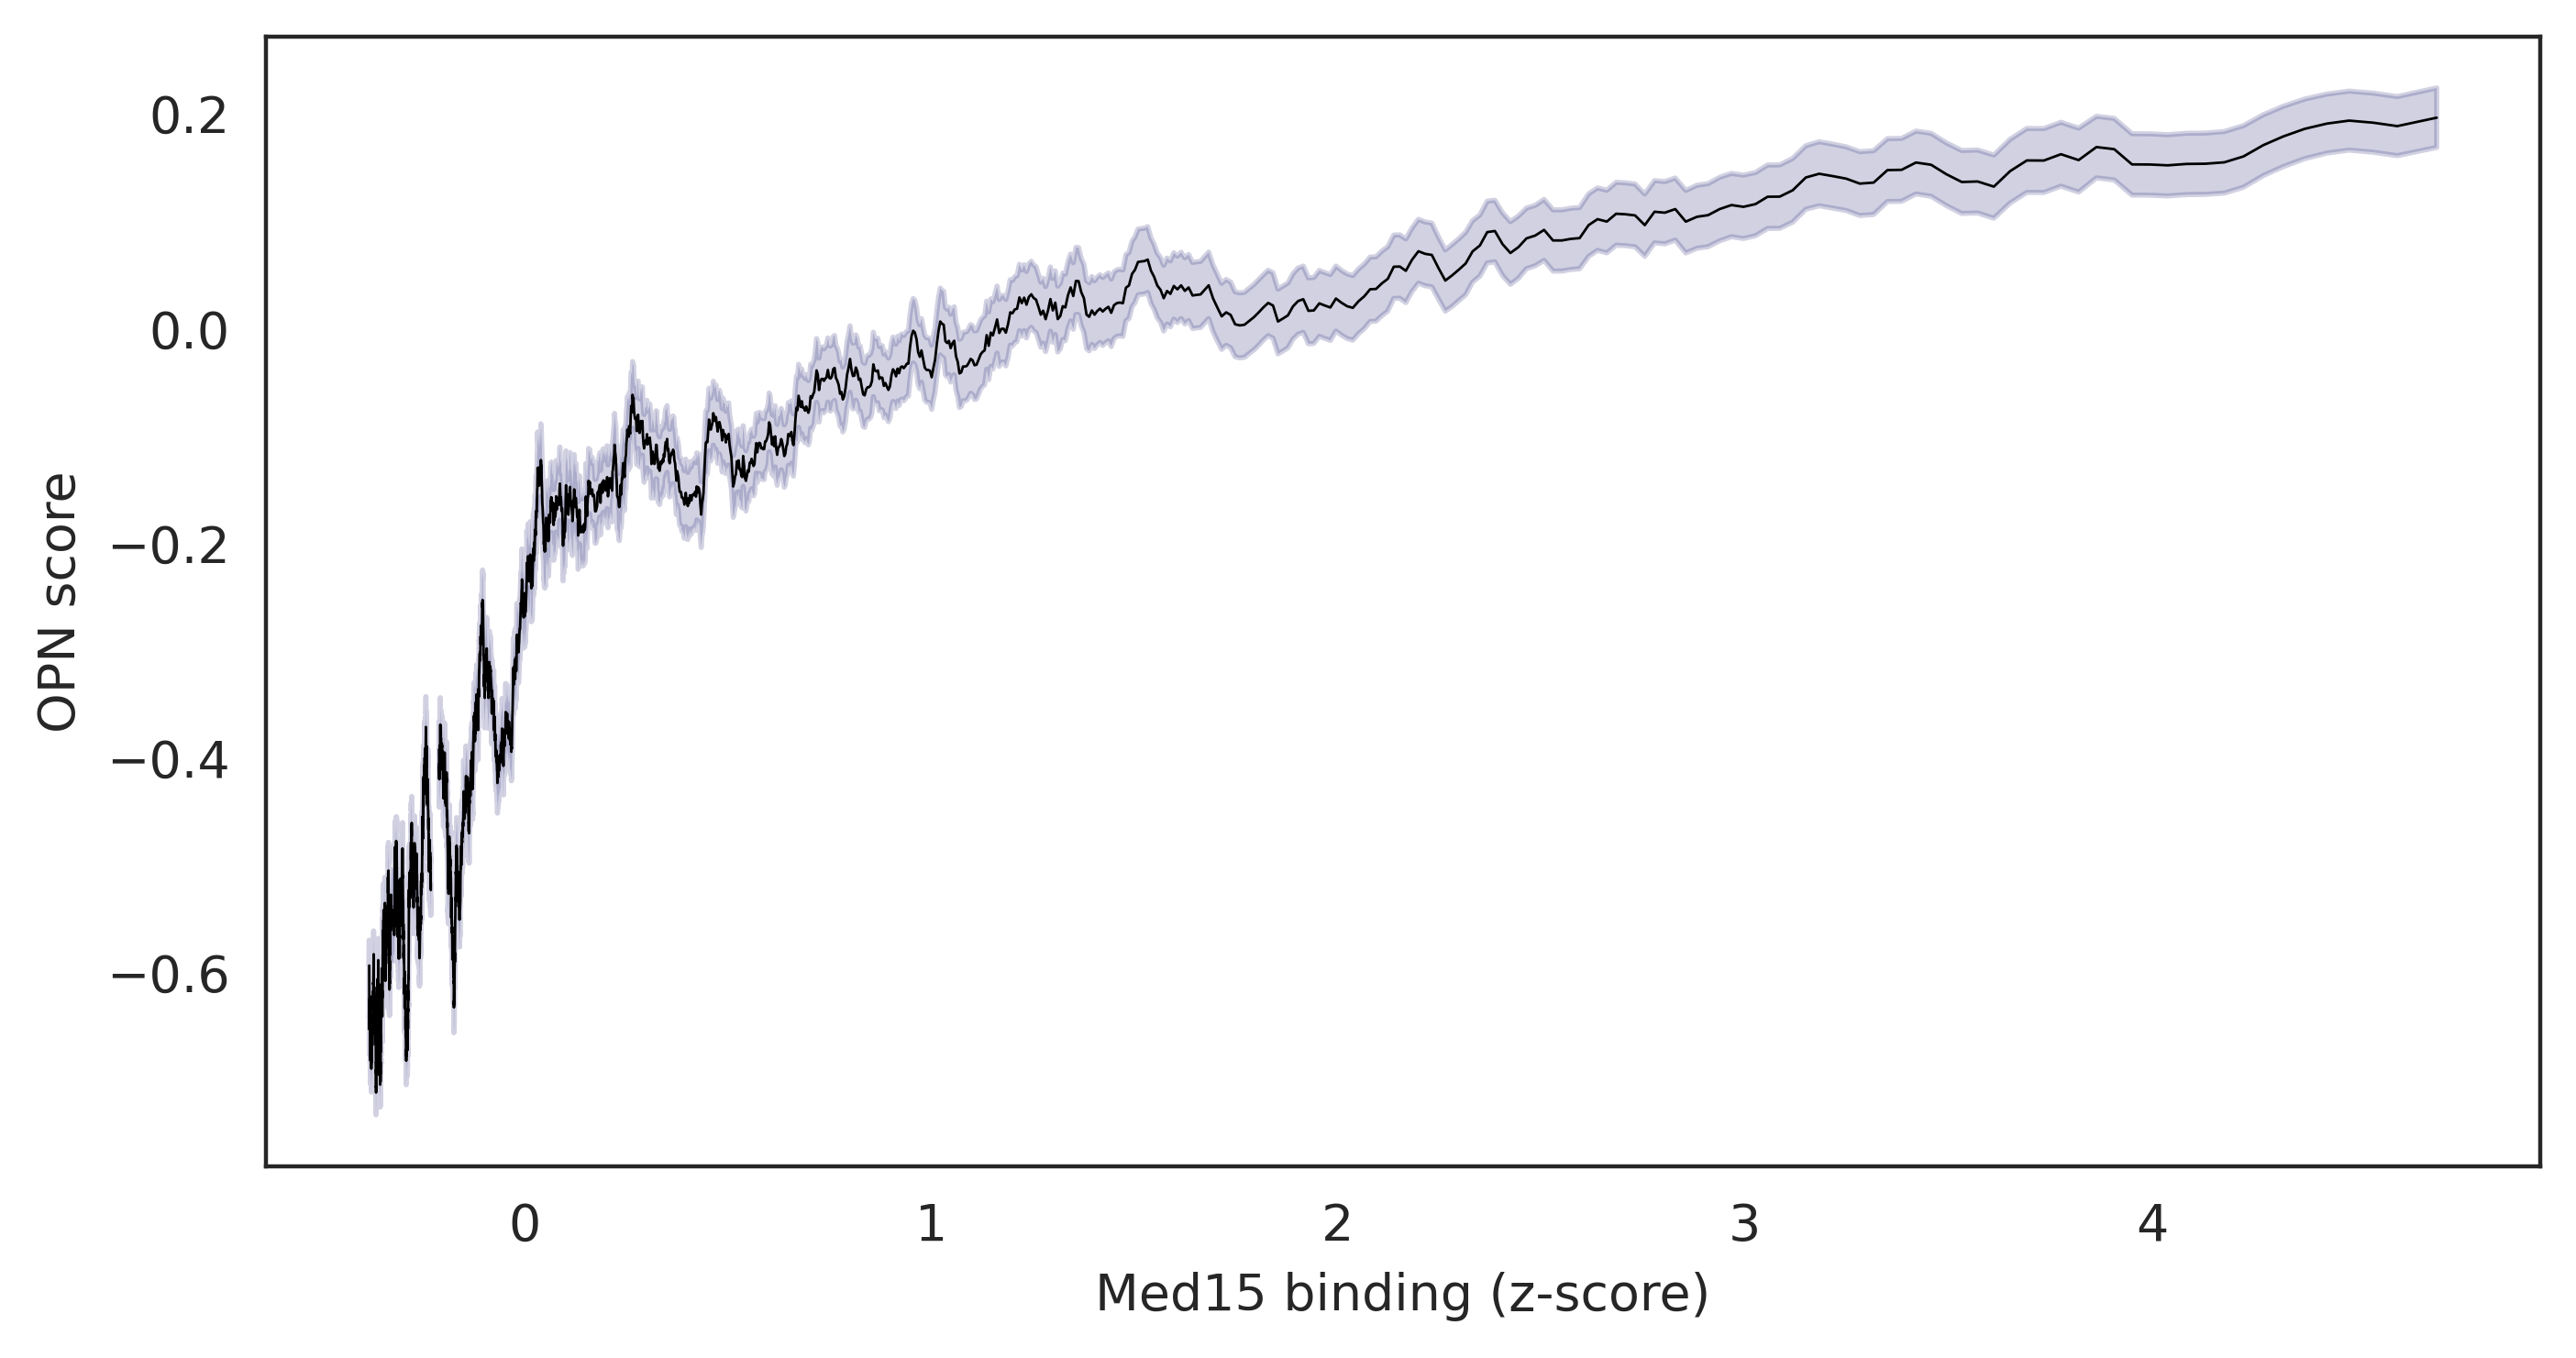

In [7]:
lwd = .5
fig, ax = plt.subplots(1, dpi=200, figsize=(8,4))
ax.plot(currd_mean.loc[:, 'Native_med15mnase'],currd_mean.loc[:, 'opn_score'], c='k', linewidth=lwd)
ax.fill_between(currd_mean.loc[:,'Native_med15mnase'], lower.loc[:, 'opn_score'],
                upper.loc[:, 'opn_score'], alpha=0.2, color='midnightblue')
ax.set_xlabel('Med15 binding (z-score)')
ax.set_ylabel('OPN score')
# fig.savefig('after_gm/fig5/medopn.pdf', bbox_inches = 'tight')

Text(1, 8.5, '# TFs')

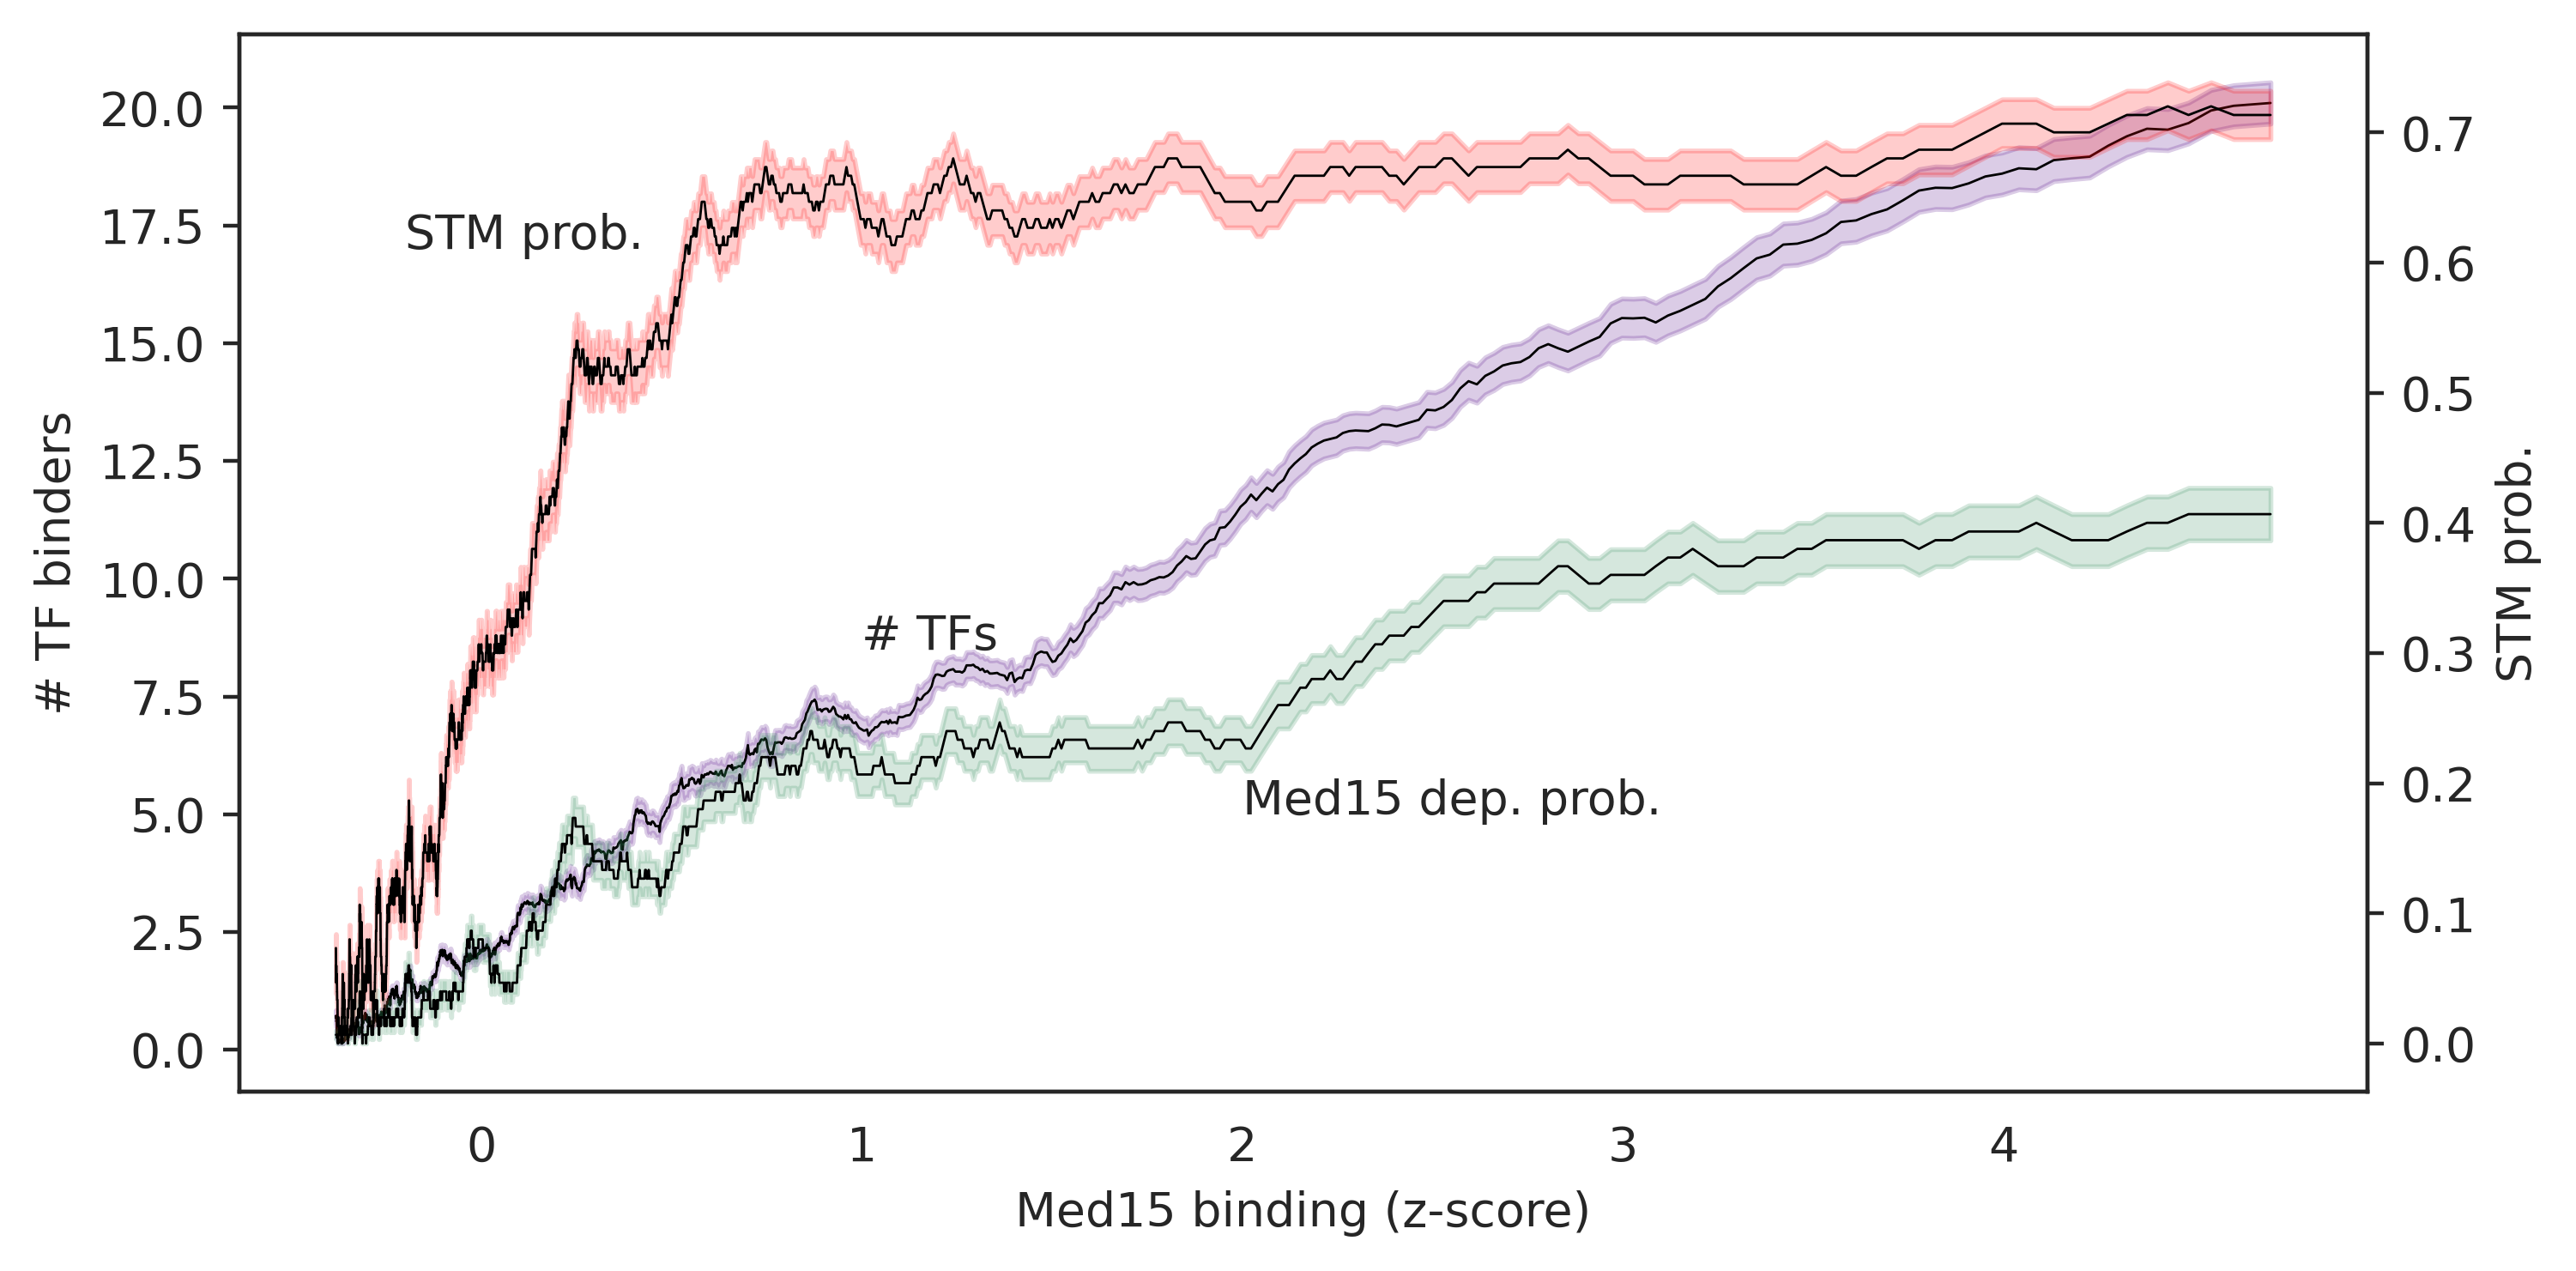

In [8]:
fig, ax = plt.subplots(1, dpi=200, figsize=(8,4))
ax.plot(currd_mean.loc[:, 'Native_med15mnase'],currd_mean.loc[:, 'numTFs_bind'], c='k', linewidth=lwd)
ax.fill_between(currd_mean.loc[:,'Native_med15mnase'], lower.loc[:, 'numTFs_bind'],
                upper.loc[:, 'numTFs_bind'], alpha=0.2, color='indigo')

twinx1 = ax.twinx()


twinx1.plot(currd_mean.loc[:, 'Native_med15mnase'],currd_mean.loc[:, 'pugh'], c='k', linewidth=lwd)
twinx1.fill_between(currd_mean.loc[:,'Native_med15mnase'], lower.loc[:, 'pugh'],
                upper.loc[:, 'pugh'], alpha=0.2, color='red')

twinx1.plot(currd_mean.loc[:, 'Native_med15mnase'],currd_mean.loc[:, 'dependence'], c='k', linewidth=lwd)
twinx1.fill_between(currd_mean.loc[:,'Native_med15mnase'], lower.loc[:, 'dependence'],
                upper.loc[:, 'dependence'], alpha=0.2, color='seagreen')

ax.set_xlabel('Med15 binding (z-score)')
ax.set_ylabel('# TF binders')
twinx1.set_ylabel('STM prob.')

ax.text(-0.2,17, 'STM prob.')
ax.text(2,5, 'Med15 dep. prob.')
ax.text(1,8.5, '# TFs')

# fig.savefig('after_gm/fig5/medall.pdf', bbox_inches = 'tight')

# Fig4C, supp. fig 8A

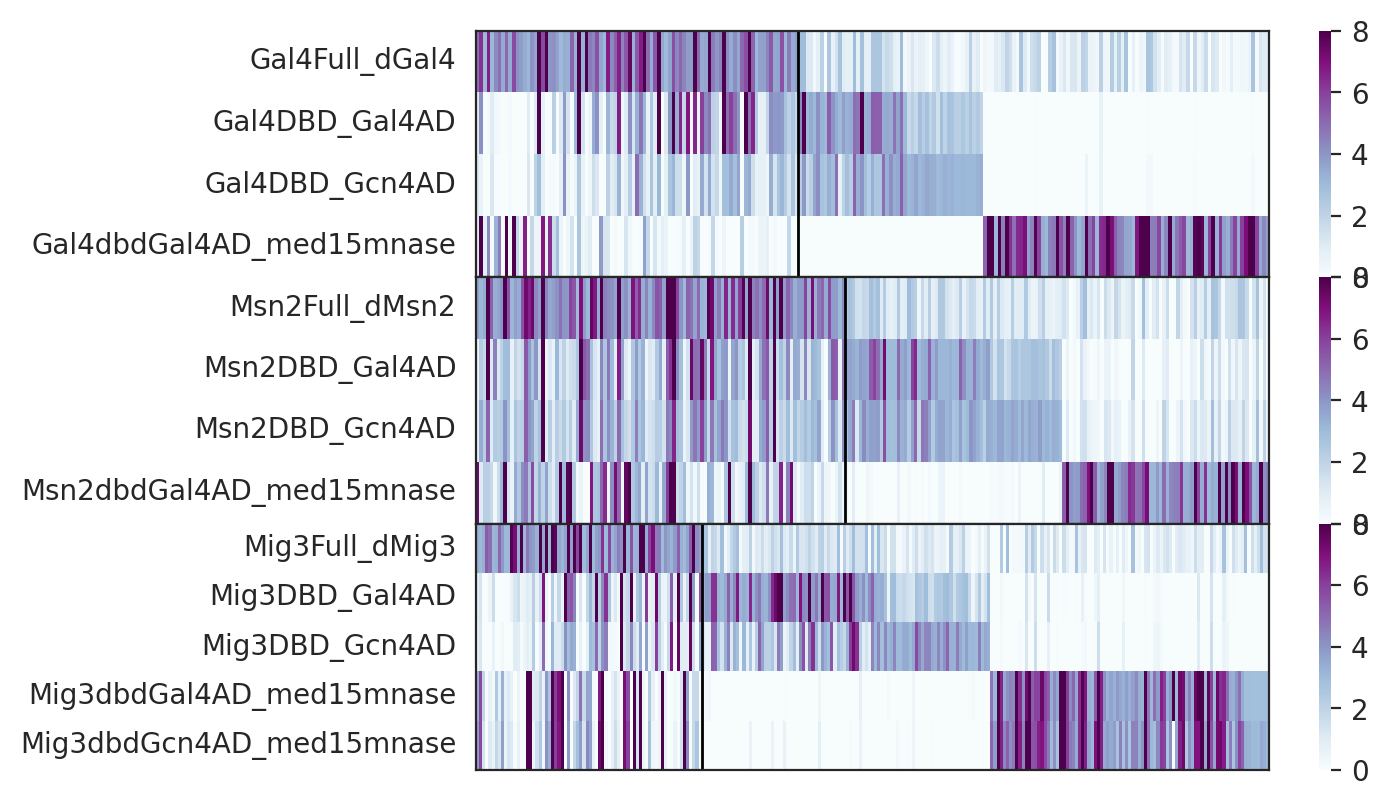

In [9]:
tsh = 3
dbdts = fg.get_targets_df(ordered_df.filter(regex='DBD'),tsh,'dbd',opn.loc[bins.index[:-1]], '').sort_index(axis=0)
wtts = fg.get_targets_df(tfs_binding_deletions_tef.filter(regex='Full').sort_index(axis=1),tsh,'wt',opn.loc[bins.index[:-1]], '').sort_index(axis=0)

log2med = np.log2(med15newdat)
d_log2med = log2med.sub(log2med.Native_med15mnase, axis=0)
d_log2med.replace([np.inf, -np.inf], np.nan, inplace=True)

wl = list()
dl = list()
stats = [1,1,2]
induc = list()
names = list()
dmed15 = list()
dbdbind = list()
wtoebind = list()
labbindl = list()
fig, ax = plt.subplots(3,1)
for numi, i in enumerate(['Gal4', 'Msn2', 'Mig3']):
    cwt = wtts.filter(regex='^'+i, axis=0).loc[:, 'wt'].values[0]
    cdbds = dbdts.filter(regex='^'+i, axis=0).loc[:, 'dbd'].values[0]
    wtbind = gn.get_zscored(tfs_binding_deletions_tef).filter(regex='Full').filter(regex='^'+i)
    labbind = gn.get_zscored(lab_dat).filter(regex='^'+i)
    clbind = gn.get_zscored(ordered_df).filter(regex='^'+i)
    
    cl1 = clbind.loc[set(cdbds).intersection(cwt)].sort_values(by=clbind.iloc[:,0].name, ascending=False)
    cl2 = clbind.loc[set(cdbds).difference(cwt)].sort_values(by=clbind.iloc[:,0].name, ascending=False)
    
    wl.extend(cl1.index.values)
    dl.extend(cl2.index.values)
    
    to_p_dat = ordered_df_all.filter(regex='^'+i)
    to_p_ts = fg.get_targets_df(to_p_dat, 3, 'tf', opn.loc[bins.index[:-1]])
    to_p_ts = pd.Index(np.concatenate(np.concatenate(to_p_ts.values))).drop_duplicates()
    plot_dat = gn.get_zscored(to_p_dat).loc[to_p_ts]
    
    wtoebind.extend(wtbind.loc[plot_dat.index].transpose().values[0])
    labbindl.extend(labbind.loc[plot_dat.index].transpose().values[0])

    induc.extend(summary_stat_d[i][0][stats[numi]].loc[plot_dat.index, 'spearman'])
    names.extend(plot_dat.index)
    dbdbind.extend(plot_dat.iloc[:,0])
    dmed15.extend(d_log2med.loc[plot_dat.index, clbind.iloc[:,1].name])

    d = sns.heatmap(plot_dat.transpose(), cmap='BuPu', vmin=0, vmax=8, ax=ax[numi], xticklabels=False)
    for _, spine in d.spines.items():
        spine.set_visible(True)
        
    ax[numi].axvline(cwt.shape[0], c='k', linewidth=1)

fig.subplots_adjust(hspace=0)


# fig.savefig('after_gm/fig5/binding.pdf', bbox_inches = 'tight')

wl = pd.Index(wl).drop_duplicates()
dl = pd.Index(dl).drop_duplicates()

df = pd.DataFrame([names, induc, dmed15, dbdbind, wtoebind, labbindl], index=['genes', 'induc', 'dmed', 'dbd','wt','lab']).transpose().dropna()

/tmp/ipykernel_102166/3898848074.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(wldl, ax=ax, palette=sns.cubehelix_palette(n_colors=3), edgecolors='k', linewidth=1, alpha=.8)


Text(0.5, 10, 'p-val<0.0001')

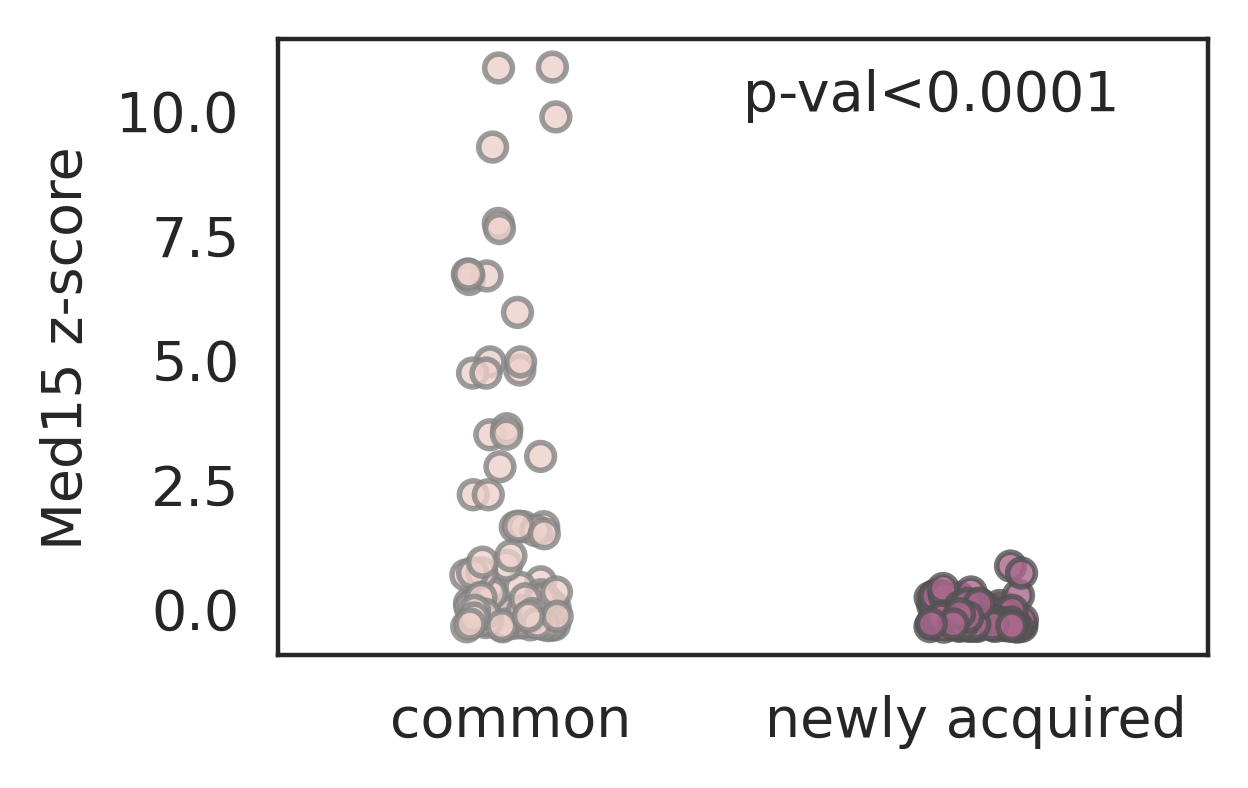

In [10]:
wldl = pd.DataFrame({i:pd.Series(native_med.loc[k].transpose().values[0]) for i,k in enumerate([wl,dl])})
wldl.columns = ['common', 'newly acquired']

fig, ax = plt.subplots(1, figsize=(3,2), dpi=200)
sns.stripplot(wldl, ax=ax, palette=sns.cubehelix_palette(n_colors=3), edgecolors='k', linewidth=1, alpha=.8)
pval = scipy.stats.ttest_ind(wldl.common.dropna(), wldl.loc[:, 'newly acquired'].dropna())[1]
ax.set_ylabel('Med15 z-score')
ax.text(.5,10,'p-val<0.0001')
# fig.savefig('after_gm/fig5/common_new_zsc.pdf', bbox_inches = 'tight')

# Fig 4D, Supp. fig 8B

In [11]:
log2med = np.log2(pd.concat([med15newdat], axis=1)).drop(['Sko1dbdGcn4AD_med15mnase','Mig3dbdGal4AD_med15mnase'], axis=1)
log2med.replace([np.inf, -np.inf], np.nan, inplace=True)
d_log2med = log2med.sub(log2med.Native_med15mnase, axis=0)
d_log2med.replace([np.inf, -np.inf], np.nan, inplace=True)
med15tf = med15newdat.loc[bins.index[:-1], log2med.columns]

tsh = 3
dbdts = fg.get_targets_df(ordered_df.filter(regex='DBD'),tsh,'dbd',opn.loc[bins.index[:-1]], '').sort_index(axis=0)
wtts = fg.get_targets_df(tfs_binding_deletions_tef.filter(regex='Full').sort_index(axis=1),tsh,'wt',opn.loc[bins.index[:-1]], '').sort_index(axis=0)

dtfmed = pd.read_csv('data/average_sp_dtf.csv', index_col=0).loc[bins.index[:-1]]

log2dtf = np.log2(dtfmed)
log2dtf.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fig.4C

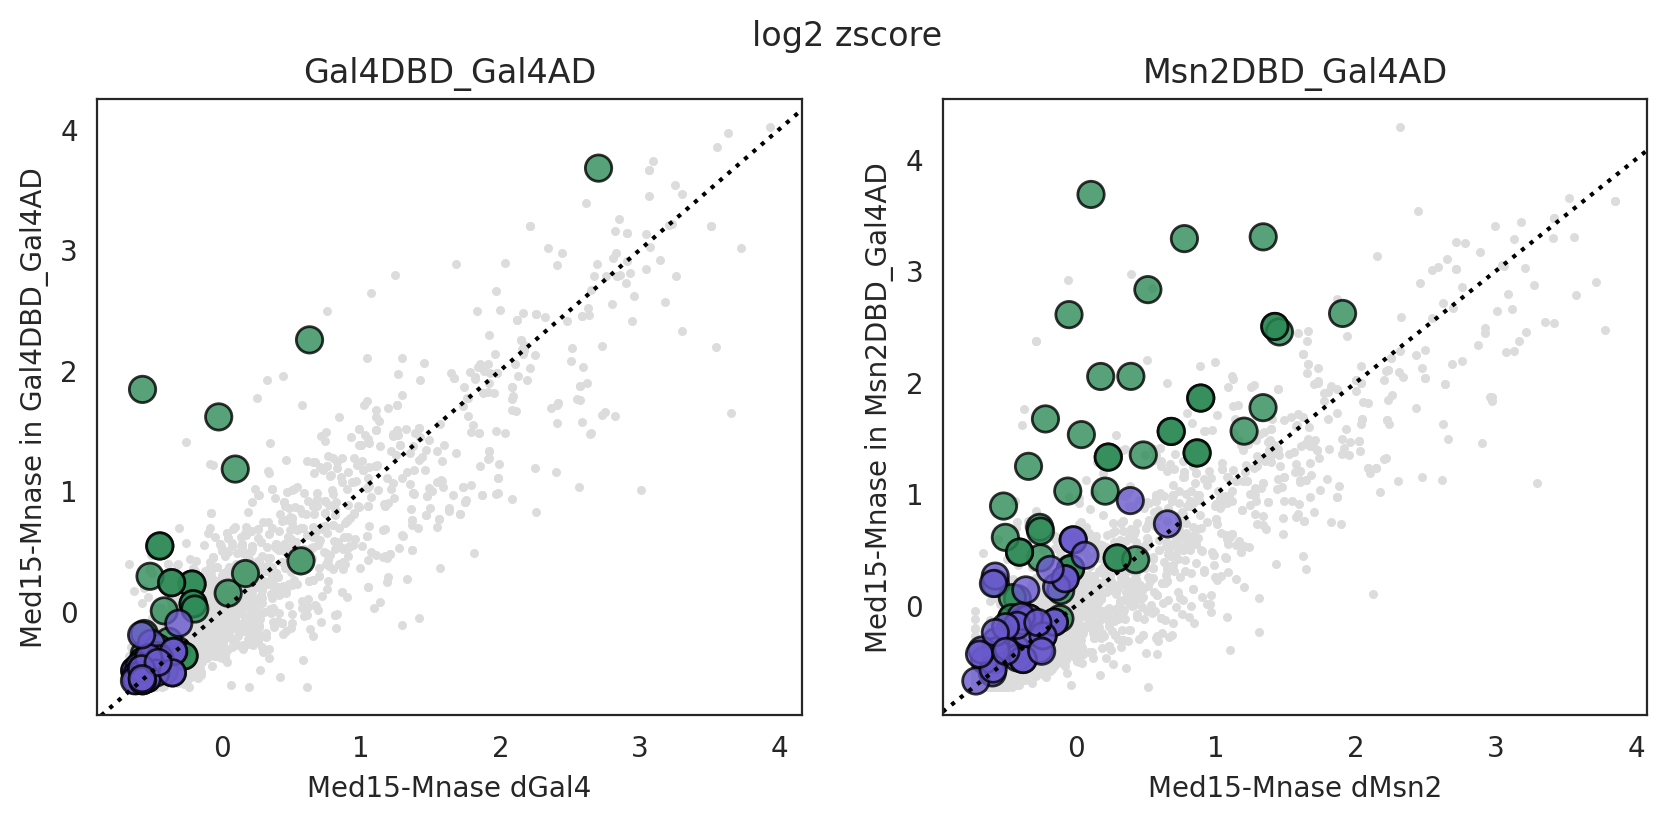

In [12]:
# plt.rcParams.update({'font.sans-serif':'Helvetica'})

fig, ax = plt.subplots(1,2, figsize=(10,4))
for numi, i in enumerate(['Gal4', 'Msn2']):
    cwt = wtts.filter(regex='^'+i, axis=0).loc[:, 'wt'].values[0]
    cdbds = dbdts.filter(regex='^'+i, axis=0).loc[:, 'dbd'].values[0]
    wtbind = gn.get_zscored(tfs_binding_deletions_tef).filter(regex='Full').filter(regex='^'+i)
    labbind = gn.get_zscored(lab_dat).filter(regex='^'+i)
    clbind = gn.get_zscored(ordered_df).filter(regex='^'+i)
    
    cl1 = clbind.loc[set(cdbds).intersection(cwt)].index
    cl2 = clbind.loc[set(cdbds).difference(cwt)].index
    allts = list(cl1)+list(cl2)

    induc = summary_stat_d[i][0][stats[numi]].loc[allts, 'spearman'].values
    fdr = summary_stat_d[i][0][stats[numi]].loc[allts, 'fdr_corr'].values
    induc[~np.logical_and(induc > 0, fdr)] = 30
    induc[np.logical_and(induc > 0, fdr)] = 120

    # print(induc)
    y_gray = np.log2(gn.get_zscored(med15tf)+1).filter(regex='^'+i).drop(allts)
    x_gray = np.log2(gn.get_zscored(dtfmed)+1).filter(regex=i).drop(allts)
    y= np.log2(gn.get_zscored(med15tf)+1).filter(regex='^'+i).loc[allts]
    x= np.log2(gn.get_zscored(dtfmed)+1).filter(regex=i).loc[allts]
    
    a = dict(zip(cl1, ['seagreen']*len(cl1)))
    a.update(dict(zip(cl2, ['slateblue']*len(cl2))))
    c = pd.DataFrame(a, index=['c']).transpose().c.values
    ax[numi].axline(xy1=(0,0), slope=1,c='k', linestyle=':')
    ax[numi].scatter(x_gray, y_gray, s=5,c='gainsboro', rasterized=True)
    sc = ax[numi].scatter(x,y,c=c,s=90, edgecolors='k', alpha=.8)
    ax[numi].set_title(clbind.columns[0])
    ax[numi].set_xlabel('Med15-Mnase d{}'.format(i))
    ax[numi].set_ylabel('Med15-Mnase in {}'.format(clbind.columns[0]))
    # handles, labels = sc.legend_elements(prop="sizes", alpha=0.6, num=5, func=lambda x:(x-30)/80)
    # legend2 = ax[numi].legend(handles, labels, loc="lower right", title="Induction")
    fig.suptitle('log2 zscore')
    # fig.savefig('../after_gm/fig5/recr_log2zscore.pdf', bbox_inches = 'tight')

# S8B

In [13]:
mig_df =  pd.concat([alltogether.filter(regex='^{}'.format(i)) for i in ['Mig3']], axis=1)
mig_df.columns = ['_'.join(k.split('_')[0:2]) for k in mig_df.columns.values]
mig_df = mig_df.drop('Mig3Full_dMig3', axis=1)
dbdts = fg.get_targets_df(mig_df,3,'dbd',opn,'')


log2med = np.log2(pd.concat([med15newdat], axis=1)).filter(regex='Mig3')
log2med.replace([np.inf, -np.inf], np.nan, inplace=True)
med15tf = med15newdat.loc[bins.index[:-1], log2med.columns]

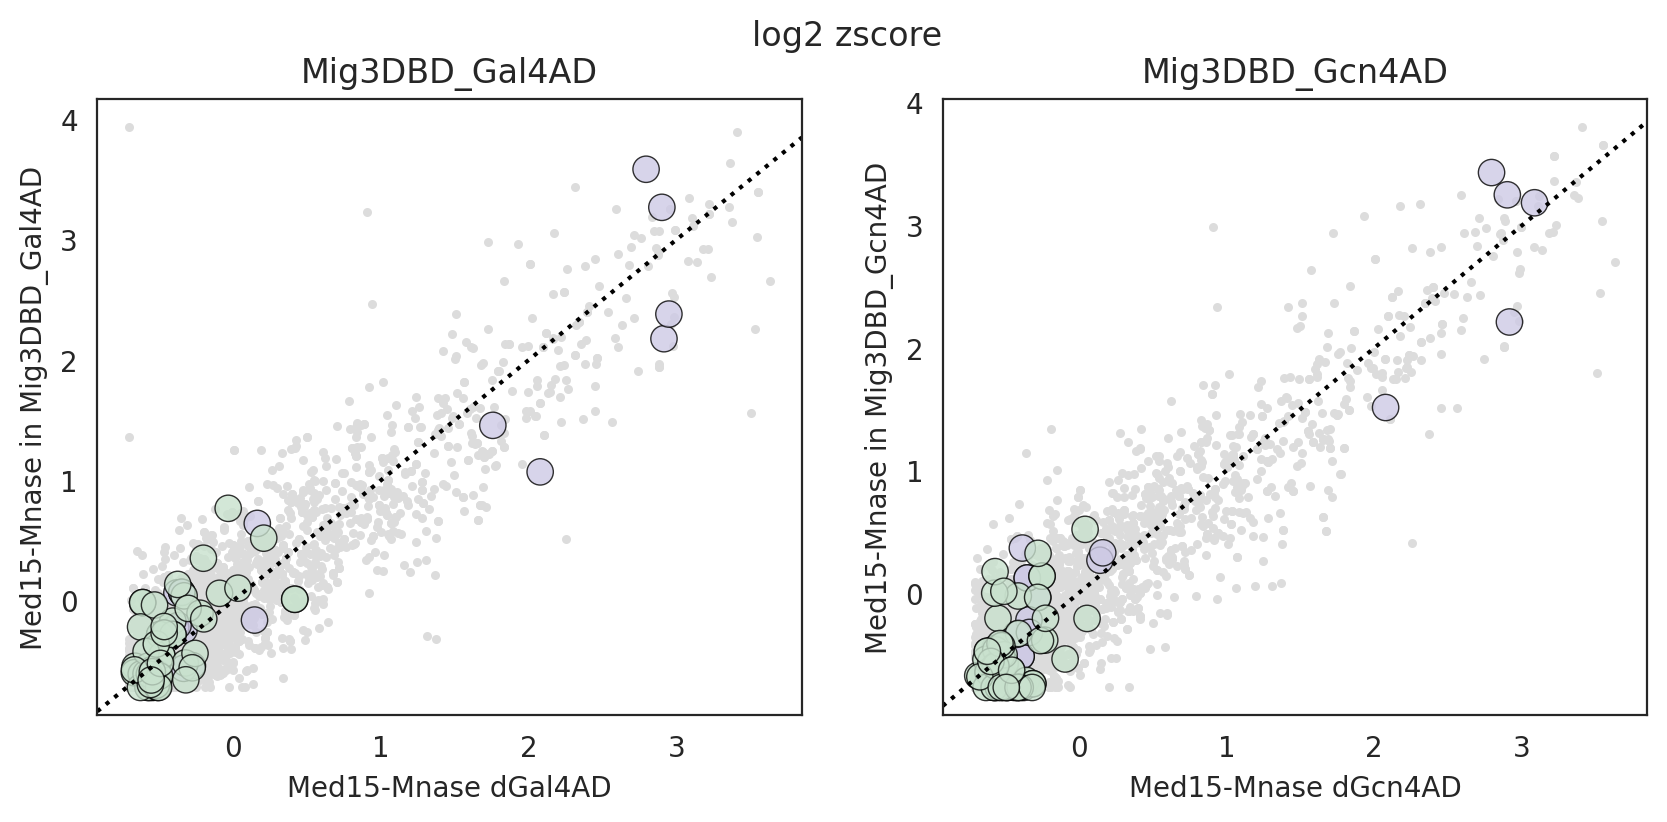

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
cwt = wtts.filter(regex='^Mig3', axis=0).loc[:, 'wt'].values[0]
wtbind = gn.get_zscored(tfs_binding_deletions_tef).filter(regex='Full').filter(regex='^Mig3')
labbind = gn.get_zscored(lab_dat).filter(regex='^Mig3')

for numi, i in enumerate(['Gal4AD', 'Gcn4AD']):
    cdbds = dbdts.filter(regex=i, axis=0).loc[:, 'dbd'].values[0]

    clbind = gn.get_zscored(mig_df).filter(regex=i)
    
    cl1 = clbind.loc[set(cdbds).intersection(cwt)].index
    cl2 = clbind.loc[set(cdbds).difference(cwt)].index
    allts = list(cl1)+list(cl2)

    induc = summary_stat_d['Mig3'][0][numi+1].loc[allts, 'spearman']
    
    y_gray = np.log2(gn.get_zscored(med15tf)+1).filter(regex=i).drop(allts)
    x_gray = np.log2(gn.get_zscored(dtfmed)+1).filter(regex='Mig3').drop(allts)
    y= np.log2(gn.get_zscored(med15tf)+1).filter(regex=i).loc[allts]
    x= np.log2(gn.get_zscored(dtfmed)+1).filter(regex='Mig3').loc[allts]
    
    a = dict(zip(cl1, ['#CECAE5']*len(cl1)))
    a.update(dict(zip(cl2, ['#C9E2CE']*len(cl2))))
    c = pd.DataFrame(a, index=['c']).transpose().c.values
    ax[numi].axline(xy1=(0,0), slope=1,c='k', linestyle=':')
    ax[numi].scatter(x_gray, y_gray, s=5,c='gainsboro', rasterized=True)
    sc = ax[numi].scatter(x,y,c=c,s=90, edgecolors='k', alpha=.8, linewidths=.5)
    ax[numi].set_title(clbind.columns[0])
    ax[numi].set_xlabel('Med15-Mnase d{}'.format(i))
    ax[numi].set_ylabel('Med15-Mnase in {}'.format(clbind.columns[0]))
    # handles, labels = sc.legend_elements(prop="sizes", alpha=0.6, num=8, func=lambda x:(x-40)/80)
    # legend2 = ax[numi].legend(handles, labels, loc="lower right", title="Induction")
    fig.suptitle('log2 zscore')
    # fig.savefig('../after_gm/fig5/recr_log2zscore_Migs.pdf', bbox_inches = 'tight')

# Fig 4E

In [15]:
log2med = np.log2(pd.concat([med15newdat], axis=1)).drop(['Sko1dbdGcn4AD_med15mnase','Mig3dbdGal4AD_med15mnase'], axis=1)
log2med.replace([np.inf, -np.inf], np.nan, inplace=True)
dmed = log2med.drop('Native_med15mnase', axis=1).sub(log2dtf.values, axis=0)
path = 'data/chec_signals/'
signals = os.listdir(path)
files = pd.DataFrame(range(len(signals)), index=signals).filter(regex='700', axis=0)
nfiles = ['Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr_700bp_signals.gz',
'Mig3DBD_Gcn4AD_dMig3_deletions_tef_3_reps_0.97_meancorr_700bp_signals.gz',
'Msn2DBD_Gal4AD_dMsn2_deletions_tef_3_reps_0.99_meancorr_700bp_signals.gz']
files=files.loc[nfiles,:]

In [16]:
tsh = 3
dbdts = fg.get_targets_df(ordered_df.filter(regex='DBD'),tsh,'dbd',opn.loc[bins.index[:-1]], '').sort_index(axis=0)
wtts = fg.get_targets_df(tfs_binding_deletions_tef.filter(regex='Full').sort_index(axis=1),tsh,'wt',opn.loc[bins.index[:-1]], '').sort_index(axis=0)

log2med = np.log2(med15newdat)
d_log2med = log2med.sub(log2med.Native_med15mnase, axis=0)
d_log2med.replace([np.inf, -np.inf], np.nan, inplace=True)

wl = list()
dl = list()
stats = [1,1,2]
induc = list()
names = list()
dmed15 = list()
dbdbind = list()
wtoebind = list()
labbindl = list()
peaks = list()
for numi, i in enumerate(['Gal4', 'Msn2','Mig3']):
    cwt = wtts.filter(regex='^'+i, axis=0).loc[:, 'wt'].values[0]
    cdbds = dbdts.filter(regex='^'+i, axis=0).loc[:, 'dbd'].values[0]
    wtbind = gn.get_zscored(tfs_binding_deletions_tef).filter(regex='Full').filter(regex='^'+i)
    labbind = gn.get_zscored(lab_dat).filter(regex='^'+i)
    clbind = gn.get_zscored(ordered_df).filter(regex='^'+i)
    
    cl1 = clbind.loc[set(cdbds).intersection(cwt)].sort_values(by=clbind.iloc[:,0].name, ascending=False)
    cl2 = clbind.loc[set(cdbds).difference(cwt)].sort_values(by=clbind.iloc[:,0].name, ascending=False)
    currf = files.filter(regex='^'+i, axis=0).index[0]
    cpeaks = pd.read_pickle(os.path.join(path, currf)).loc[cdbds].rolling(window=50, axis=1, center=True).mean(skipna=True).idxmax(axis=1).values
    peaks.extend(cpeaks)
    wl.extend(cl1.index.values)
    dl.extend(cl2.index.values)
    
    plot_dat = pd.concat([cl1, cl2], axis=0)
    wtoebind.extend(wtbind.loc[plot_dat.index].transpose().values[0])
    labbindl.extend(labbind.loc[plot_dat.index].transpose().values[0])

    induc.extend(summary_stat_d[i][0][stats[numi]].loc[plot_dat.index, 'spearman'])
    names.extend(plot_dat.index)
    dbdbind.extend(plot_dat.iloc[:,0])
    dmed15.extend(dmed.loc[plot_dat.index, clbind.iloc[:,1].name])

wl = pd.Index(wl).drop_duplicates()
dl = pd.Index(dl).drop_duplicates()

df = pd.DataFrame([names, induc, dmed15, dbdbind, wtoebind, labbindl, peaks],
                  index=['genes', 'induc', 'dmed', 'dbd','wt','lab', 'peaks']).transpose().dropna()
df.index = df.genes
params = pd.read_csv('data/params_compendium.csv', index_col=0)

df_all_pars = pd.concat([df, params.loc[df.genes.values]], axis=1)
df_all_pars.loc[:, 'pugh'] = df_all_pars.pugh.map(lambda x: True if x=='02_STM' else False)
df_all_pars.loc[:, 'dependence'] =  df_all_pars.dependence.map(lambda x: True if x == 'tail_dependent' else False)
df_all_pars = df_all_pars.drop('genes', axis=1)

Text(0, 0.5, 'dmed')

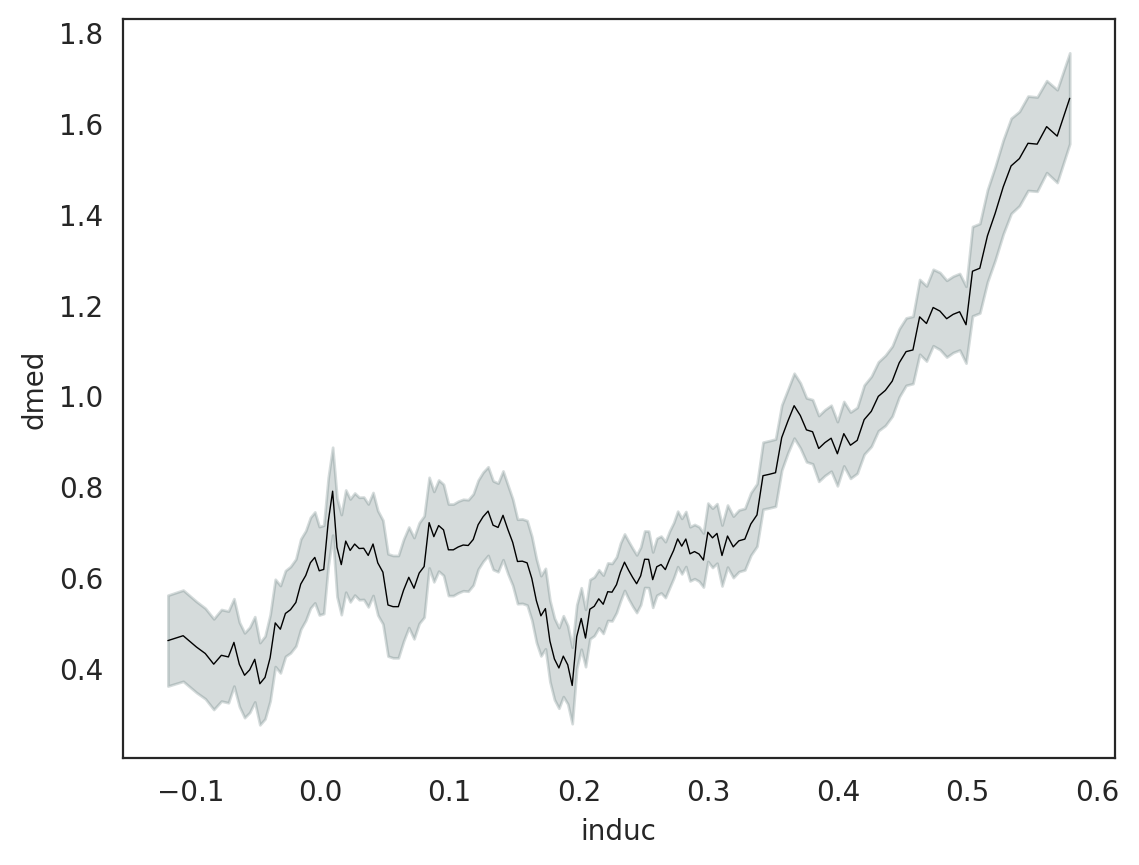

In [17]:
wind=50
currd_mean = df_all_pars.dropna().\
sort_values(by='induc').rolling(window=wind, center=True).mean().dropna()
currd_std = (df_all_pars.dropna().\
sort_values(by='induc').rolling(window=wind, center=True).sem()*0.5).dropna()

lower = currd_mean - currd_std
upper = currd_mean + currd_std
lwid=.5

fig, ax = plt.subplots(1)
ax.plot(currd_mean.loc[:,'induc'], currd_mean.loc[:,'dmed'], c='k', linewidth=lwid)
ax.fill_between(currd_mean.loc[:,'induc'], lower.loc[:, 'dmed'], upper.loc[:, 'dmed'], alpha=0.2, color='darkslategray')
ax.set_xlabel('induc')
ax.set_ylabel('dmed')

# fig.savefig('after_gm/fig5/induc_vs_dmed.pdf', bbox_inches = 'tight')